# Classifier Training Notebook
This notebook creates and trains the classifier model. This notebook can be run after the encoder notebook or on its own. Many of the functions found here are similar to the ones found in the encoder notebook. The labels are created by splitting the normalized feel trace ([0,1]) into discrete classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from scipy import signal

import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

from tqdm import tqdm

#### Load dataset

In [2]:
def split_filtered_and_raw(filtered_data : list, raw_data : list, random_seed=128) -> list:
    
    autoencoder_split, classifier_split = train_test_split(filtered_data, test_size=0.7, random_state=random_seed, shuffle=True)
    autoencoder_split_raw, classifier_split_raw = train_test_split(raw_data, test_size=0.7, random_state=random_seed, shuffle=True)
    
    # split data into train and test
    autoencoder_train, autoencoder_test = train_test_split(np.array(autoencoder_split), test_size=0.2, random_state=random_seed, shuffle=True)
    autoencoder_train_raw, autoencoder_test_raw = train_test_split(np.array(autoencoder_split_raw), test_size=0.2, random_state=random_seed, shuffle=True)
    
    classifier_train, classifier_test = train_test_split(np.array(classifier_split), test_size=0.2, random_state=random_seed, shuffle=True)
    classifier_train_raw, classifier_test_raw = train_test_split(np.array(classifier_split_raw), test_size=0.2, random_state=random_seed, shuffle=True)

    
    # further split train into validation and train
    autoencoder_train, autoencoder_val = train_test_split(autoencoder_train, test_size=0.2, random_state=random_seed, shuffle=True)
    autoencoder_train_raw, autoencoder_val_raw = train_test_split(autoencoder_train_raw, test_size=0.2, random_state=random_seed, shuffle=True)
    
    classifier_train, classifier_val = train_test_split(classifier_train, test_size=0.2, random_state=random_seed, shuffle=True)
    classifier_train_raw, classifier_val_raw = train_test_split(classifier_train_raw, test_size=0.2, random_state=random_seed, shuffle=True)
    
    
    split_dataset = [autoencoder_train, autoencoder_val, autoencoder_test, autoencoder_train_raw, autoencoder_val_raw, autoencoder_test_raw,
                     classifier_train, classifier_val, classifier_test, classifier_train_raw, classifier_val_raw, classifier_test_raw]
    return split_dataset
    

def load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, cutoff_lf=4, random_seed=128, num_subjects = 5, subject_choice_seed=128):
    subject_data_files = glob.glob(os.path.join(eeg_ft_dir, '*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    # group data, pick num_subjects randomly
    np.random.seed(subject_choice_seed)
    all_eeg_ft_names = np.random.choice(subject_data_files, size=num_subjects, replace=False)
    print(f"Chosen subjects: {all_eeg_ft_names}")
    
    if cutoff_lf is not None:
        sos = signal.butter(10, cutoff_lf, 'lp', fs=1000, output='sos') # low pass filter
    
    
    full_dataset = []
    for x in all_eeg_ft_names:        
        dataset = []
        unfiltered = []
        
        input_label_pair = pd.read_csv(x).values
        input_label_pair_unfiltered = input_label_pair.copy()
        
        if cutoff_lf is not None:
            input_label_pair[:,2:] = signal.sosfiltfilt(sos, input_label_pair[:,2:], axis=0)
        
        n_chunks = len(input_label_pair)/split_size
        
        split_data = np.array_split(input_label_pair, n_chunks).copy()
        split_data_unfiltered = np.array_split(input_label_pair_unfiltered, n_chunks).copy()
        
        del input_label_pair_unfiltered
        del input_label_pair
        
        for x_split, y_split in zip(split_data, split_data_unfiltered):
                if len(x_split) >= split_size:
                    dataset.append(x_split[:split_size].copy())
                    unfiltered.append(y_split[:split_size].copy())
                    
        split_dataset = split_filtered_and_raw(dataset, unfiltered, random_seed) # split data into train, validation and test sets
        
        full_dataset.append(split_dataset)
    return convert_loaded_dataset(full_dataset)

def convert_loaded_dataset(full_dataset):
    '''
    convert the full list into individual numpy arrays
    '''
    return [np.vstack([x[i] for x in full_dataset]) for i in range(12) ]

In [3]:
from sklearn.model_selection import train_test_split
dataset = load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, cutoff_lf=4, random_seed=128, num_subjects = 1, subject_choice_seed=55)

classifier_train, classifier_val, classifier_test = dataset[6:9]
classifier_train_raw, classifier_val_raw, classifier_test_raw = dataset[9:]

Chosen subjects: ['ALIGNED_DATA/EEG_FT_ALIGNED_9.csv']


#### Visualize Dataset

1782


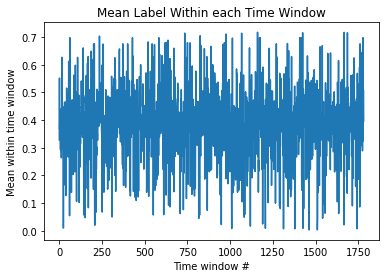

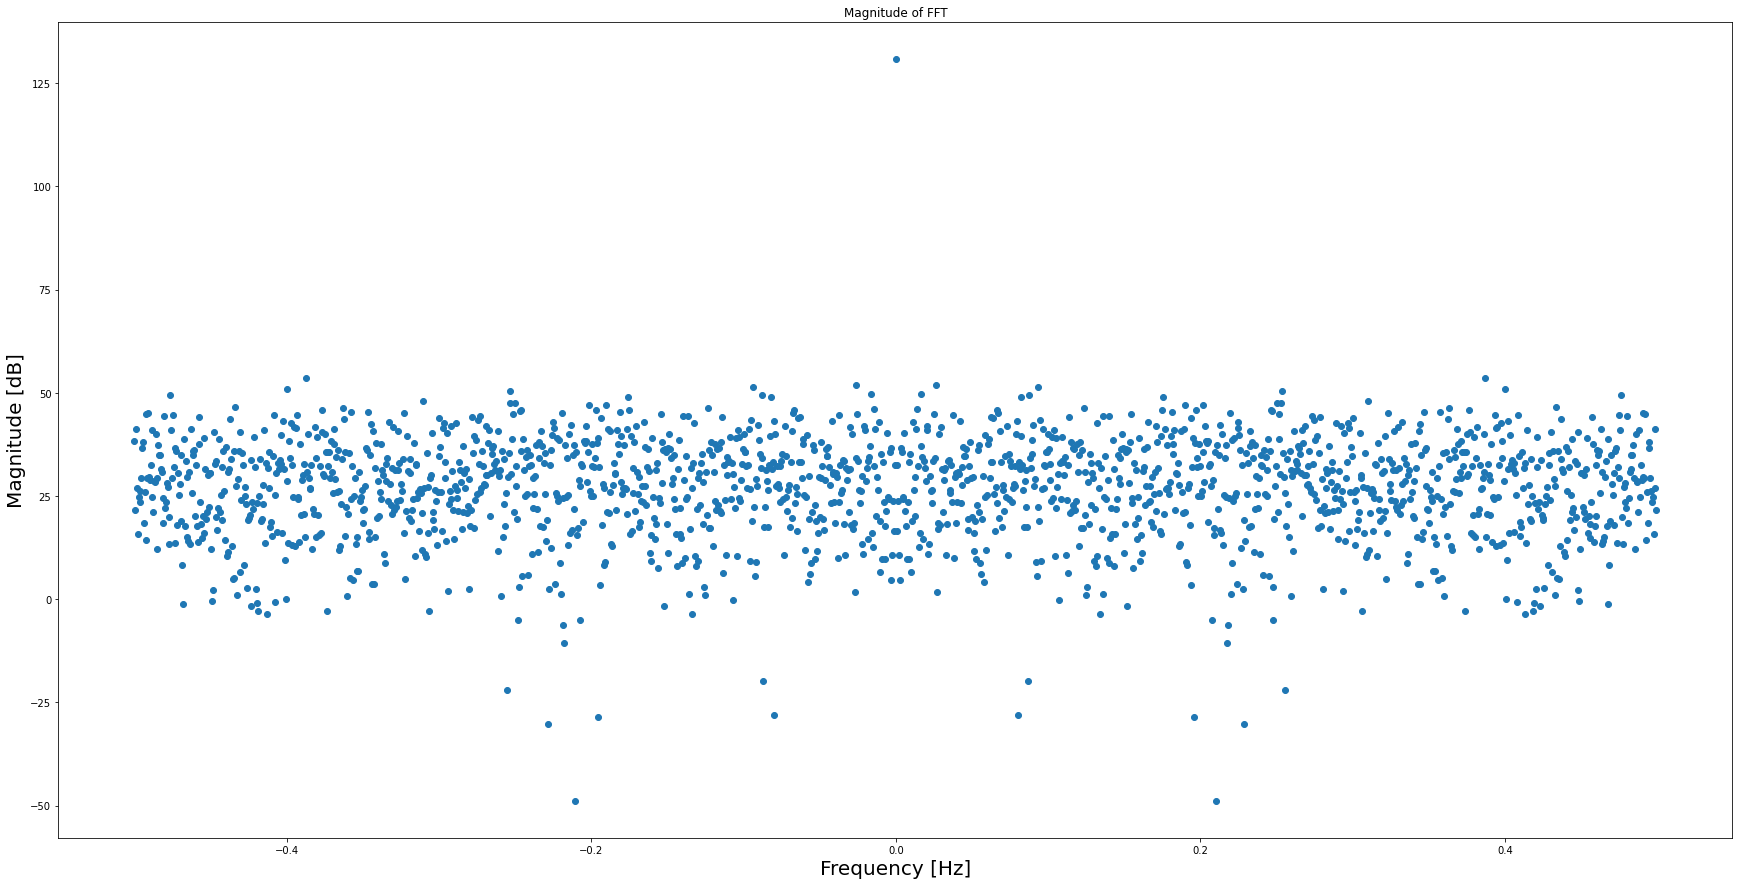

In [4]:
data = classifier_test[:, :, 1].mean(axis=-1)
freq = np.fft.fftfreq(data.size)
print(data.size)
plt.plot(np.arange(data.shape[0]), data)
plt.xlabel("Time window #")
plt.ylabel("Mean within time window")
plt.title("Mean Label Within each Time Window")
fig, axs = plt.subplots(figsize=(30,15))
fft_window = np.abs(np.fft.fft(data))


axs.scatter( freq, 20*np.log(fft_window))

axs.set_xlabel('Frequency [Hz]', fontsize=20);
axs.set_ylabel('Magnitude [dB]', fontsize=20)
axs.set_title(f"Magnitude of FFT")
plt.show()

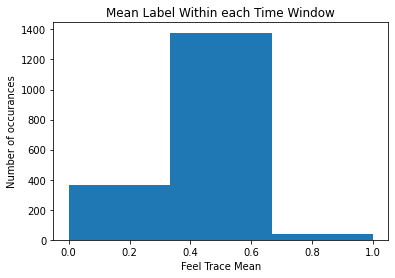

In [21]:
plt.hist(data, bins=3, range=(0,1))
plt.xlabel("Feel Trace Mean")
plt.ylabel("Number of occurances")
plt.title("Mean Label Within each Time Window")
plt.show()

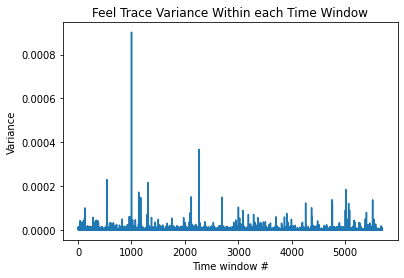

In [8]:
plt.plot(classifier_train[:, :, 1].var(axis=-1))
plt.xlabel("Time window #")
plt.ylabel("Variance")
plt.title("Feel Trace Variance Within each Time Window")
plt.show()

In [9]:
class autoencoder(nn.Module):
    def __init__(self, num_features=12):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(32, num_features))
        self.decoder = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x


def encode_classifier_data(encoder_path="models/ae_model_100ms_subject_0_4Hz_8_features.pth", classifier_data_in=classifier_test, encoding=8):
    ae_model = autoencoder(encoding)
    ae_model.load_state_dict(torch.load(encoder_path))
    ae_model.eval()
    with torch.no_grad():
        prev_shape = classifier_data_in.shape
        x = torch.from_numpy(classifier_data_in[:,:,2:]).float().reshape(-1,1,64) # eeg channels
        x_encoded = ae_model.encode(x).reshape(prev_shape[0], prev_shape[1], encoding).numpy()

        tmp_arr = np.zeros((prev_shape[0], prev_shape[1], 2 + encoding))
        tmp_arr[:, :, :2] = classifier_data_in[:,:,:2].copy() # copy timestamps and feel trace
        tmp_arr[:,:, 2:] = x_encoded # copy encoded eeg
        return tmp_arr

In [10]:
encoder_path = '1_subjects_seed_55_encoder_8_feat.pth'

classifier_test = encode_classifier_data(encoder_path=encoder_path, classifier_data_in=classifier_test, encoding=8)
classifier_val = encode_classifier_data(encoder_path=encoder_path, classifier_data_in=classifier_val, encoding=8)
classifier_train = encode_classifier_data(encoder_path=encoder_path, classifier_data_in=classifier_train, encoding=8)

In [16]:
classifier_test.shape

(1782, 100, 10)

#### Classifier Model

In [12]:
class lstm_classifier(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=5):
        super(lstm_classifier, self).__init__()
        
        self.hidden_size = num_hidden*2
        self.num_features = num_features
        self.input_size = num_hidden
        self.n_classses = n_labels
        
        self.lstm_1 = nn.LSTM(
            input_size =  self.num_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first=True
        )
        
        self.lstm_2 = nn.LSTM(
            input_size =  self.hidden_size,
            hidden_size = self.input_size,
            num_layers = 1,
            batch_first=True
        )
        
        self.classify = nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, self.n_classses))

    
    def forward(self,x):
        x, (h_t, c_t) = self.lstm_1(x)
        x, (h_t, c_t) = self.lstm_2(x)
        x = self.classify(h_t[-1]) # classify last hidden timestep
        return x

In [13]:
def stress_2_label(mean_stress, n_labels=5):
    # value is in [0,1] so map to [0,labels-1] and discretize
    return np.digitize(mean_stress * n_labels, np.arange(n_labels)) - 1

class classifier_dataset(torch.utils.data.Dataset):
    def __init__(self, X, n_labels=5):
        'Initialization'
        self.x = X
        self.n_labels = n_labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = torch.from_numpy(self.x[index,:,2:]).float() # eeg channels
        y = np.array(stress_2_label(self.x[index, :, 1].mean(axis=-1), n_labels=self.n_labels)).astype(int)
        y = torch.from_numpy(y) # feel trace labels int value [0,n_labels]
        return x, y

#### Training Loop

In [14]:
def train(model, num_epochs=5, batch_size=1, learning_rate=1e-3, train_split=classifier_train, test_split=classifier_val, n_labels=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()
    train_dataset = classifier_dataset(train_split, n_labels=n_labels)
    test_dataset = classifier_dataset(test_split, n_labels=n_labels)
    
    # figure out class distribution to over sample less represented classes
    train_labels = stress_2_label(train_split[:,:,1].mean(axis=-1), n_labels).astype(int)
    test_labels = stress_2_label(test_split[:,:,1].mean(axis=-1), n_labels).astype(int)
    
    # get the weights of each class as 1/occurance
    train_class_weight= 1/np.bincount(train_labels, minlength=n_labels)
    test_class_weight = 1/np.bincount(test_labels, minlength=n_labels)
    
    # get the per sample weight, which is the likelihood os sampling
    train_sample_weights = [train_class_weight[x] for x in train_labels]
    test_sample_weights = [test_class_weight[x] for x in test_labels]
    
    # sampler
    train_sampler = torch.utils.data.WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)
    test_sampler = torch.utils.data.WeightedRandomSampler(test_sample_weights,  len(test_sample_weights), replacement=True)
    
        
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               sampler=train_sampler)
    
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               sampler=test_sampler)
    
    train_metrics = []
    test_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_acc = 0 # accuracy
        cur_train_pc = 0 # precision
        cur_train_rc = 0 # recall
        cur_train_f1 = 0 # f1
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            y_hat_np = F.softmax(y_hat.detach(), dim=1).argmax(axis=1).cpu().numpy().squeeze().reshape(-1,) # predictions
            y_np = y.detach().cpu().numpy().squeeze().reshape(-1,) # labels
            
            # metrics
            prf = precision_recall_fscore_support(y_np, y_hat_np, average='macro', zero_division=0)
            
            cur_train_acc += np.mean(y_hat_np == y_np)
            cur_train_pc += prf[0]
            cur_train_rc += prf[1]
            cur_train_f1 += prf[2]
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_acc  = cur_train_acc/train_loop_size
        cur_train_pc   = cur_train_pc/train_loop_size
        cur_train_rc   = cur_train_rc/train_loop_size
        cur_train_f1   = cur_train_f1/train_loop_size
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_acc, cur_train_pc, cur_train_rc, cur_train_f1, cur_train_loss])
        
        with torch.no_grad():
            
            # reset metrics
            cur_test_acc = 0 # accuracy
            cur_test_pc = 0 # precision
            cur_test_rc = 0 # recall
            cur_test_f1 = 0 # f1
            cur_test_loss = 0 # loss
            
            # set to evaluate mode, ignores dropout
            model.eval()
            
            # loop over dataset
            for data in tqdm(test_loader):
                x, y = data
                x = x.to(device)
                y = y.to(device)
                
                y_hat = model(x)
                loss = criterion(y_hat, y)
                
                y_hat_np = F.softmax(y_hat.detach(), dim=1).argmax(axis=1).cpu().numpy().squeeze().reshape(-1,)
                y_np = y.detach().cpu().numpy().squeeze().reshape(-1,)
                
                # metrics
                prf = precision_recall_fscore_support(y_np, y_hat_np, average='macro', zero_division=0)
                
                cur_test_acc += np.mean(y_hat_np == y_np)
                cur_test_pc += prf[0]
                cur_test_rc += prf[1]
                cur_test_f1 += prf[2]
                cur_test_loss += loss.detach().cpu()
                
                
            # average metrics over loop
            test_loop_size = len(test_loader)
            cur_test_acc  = cur_test_acc/test_loop_size
            cur_test_pc   = cur_test_pc/test_loop_size
            cur_test_rc   = cur_test_rc/test_loop_size
            cur_test_f1   = cur_test_f1/test_loop_size
            cur_test_loss = cur_test_loss/test_loop_size
        
            test_metrics.append([cur_test_acc, cur_test_pc, cur_test_rc, cur_test_f1, cur_test_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss},'\
              f'\nTrain Accuracy:{cur_train_acc},'\
              f'\nTrain Recall: {cur_train_rc},'\
              f'\nTrain precision: {cur_train_pc},' \
              f'\nTrain F1-Score:{cur_train_f1},' \
              f'\nTest Loss:{cur_test_loss},' \
              f'\nTest Accuracy:{cur_test_acc},' \
              f'\nTest Recall: {cur_test_rc},' \
              f'\nTest precision: {cur_test_pc},' \
              f'\nTest F1-Score:{cur_test_f1}')
        
    return train_metrics, test_metrics

#### Run Training

In [22]:
time_window=100 # 100ms, non - overlapping
num_features=8 # 64 channels for input features, eeg input
num_hidden = 32 # LSTM parameter, the larger the more complicated the model
n_classes = 3 # number of ouputs for our classifier, split the range [0,1] into n_classes


classifier_model = lstm_classifier(num_features=num_features, num_hidden=num_hidden, dropout=0.0, n_labels=n_classes)
n_epochs=50
train_metrics, test_metrics = train(classifier_model, n_epochs, batch_size=512, learning_rate=1e-3, train_split=classifier_train, test_split=classifier_val, n_labels=n_classes)


#model.load_state_dict(torch.load("cnn_ae_model.pth"))
#model_path = "models/classify_model.pth"
#torch.save(classifier_model.state_dict(), model_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.25it/s]


Epoch:1,
Train Loss:1.0753282308578491,
Train Accuracy:0.5330330768034827,
Train Recall: 0.5367473369265312,
Train precision: 0.5033405088269438,
Train F1-Score:0.497006804979044,
Test Loss:1.0382657051086426,
Test Accuracy:0.6654960905029094,
Test Recall: 0.6573172989166278,
Test precision: 0.6570046431769234,
Test F1-Score:0.6520746595169197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.12it/s]


Epoch:2,
Train Loss:0.966984748840332,
Train Accuracy:0.6373625038868159,
Train Recall: 0.636940543546184,
Train precision: 0.6347170021583585,
Train F1-Score:0.6329900913171875,
Test Loss:0.8587109446525574,
Test Accuracy:0.6849753870532004,
Test Recall: 0.6772287942098462,
Test precision: 0.680869461625813,
Test F1-Score:0.6730521744274509


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.92it/s]


Epoch:3,
Train Loss:0.7798108458518982,
Train Accuracy:0.6798186800373135,
Train Recall: 0.6802310667053509,
Train precision: 0.6805961156178829,
Train F1-Score:0.6779587930479526,
Test Loss:0.6912870407104492,
Test Accuracy:0.7326004649833749,
Test Recall: 0.7359182829728822,
Test precision: 0.7465082156692562,
Test F1-Score:0.7224079334853938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.21it/s]


Epoch:4,
Train Loss:0.6614018082618713,
Train Accuracy:0.7244271805037313,
Train Recall: 0.7285556945492613,
Train precision: 0.7433621521253557,
Train F1-Score:0.7142562347097888,
Test Loss:0.6388517022132874,
Test Accuracy:0.7358962619492934,
Test Recall: 0.7355342776645614,
Test precision: 0.7589282108526664,
Test F1-Score:0.725994334142249


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.50it/s]


Epoch:5,
Train Loss:0.6290197968482971,
Train Accuracy:0.7207055542599502,
Train Recall: 0.7191568425974991,
Train precision: 0.7607711378762286,
Train F1-Score:0.7154908338056724,
Test Loss:0.6272009611129761,
Test Accuracy:0.7115284704904407,
Test Recall: 0.7163239078406024,
Test precision: 0.7361982546619732,
Test F1-Score:0.7007951973102128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.22it/s]


Epoch:6,
Train Loss:0.6097639203071594,
Train Accuracy:0.7358082633706468,
Train Recall: 0.7313174564693167,
Train precision: 0.7549166362276988,
Train F1-Score:0.721545476075658,
Test Loss:0.545654833316803,
Test Accuracy:0.7750464333956776,
Test Recall: 0.7696963641473885,
Test precision: 0.8000217507922341,
Test F1-Score:0.7643280674682279


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.05it/s]


Epoch:7,
Train Loss:0.521857500076294,
Train Accuracy:0.7985511893656717,
Train Recall: 0.7962089245972358,
Train precision: 0.8098573159833585,
Train F1-Score:0.7908160443160241,
Test Loss:0.554122805595398,
Test Accuracy:0.7632692357647547,
Test Recall: 0.7610892728178529,
Test precision: 0.7794295047525083,
Test F1-Score:0.7541515862085001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.11it/s]


Epoch:8,
Train Loss:0.5682888031005859,
Train Accuracy:0.7336219294154228,
Train Recall: 0.735200581582136,
Train precision: 0.7682734747088767,
Train F1-Score:0.7299566406271712,
Test Loss:0.5211789608001709,
Test Accuracy:0.7903110063383209,
Test Recall: 0.7866937630673693,
Test precision: 0.7984767129263749,
Test F1-Score:0.7813735039208599


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.22it/s]


Epoch:9,
Train Loss:0.683028519153595,
Train Accuracy:0.7291229399875622,
Train Recall: 0.7306751388577005,
Train precision: 0.739631935097079,
Train F1-Score:0.7271346114689073,
Test Loss:0.6109151244163513,
Test Accuracy:0.7390004805694098,
Test Recall: 0.7449066919732189,
Test precision: 0.7482737744809316,
Test F1-Score:0.7303816931106462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.32it/s]


Epoch:10,
Train Loss:0.5674663186073303,
Train Accuracy:0.7664873872823383,
Train Recall: 0.7684380535161633,
Train precision: 0.7711096017617219,
Train F1-Score:0.7622069769638132,
Test Loss:0.5119686722755432,
Test Accuracy:0.8046631468204488,
Test Recall: 0.8082776762298979,
Test precision: 0.8067572184225414,
Test F1-Score:0.8008155739603104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.78it/s]


Epoch:11,
Train Loss:0.4531688690185547,
Train Accuracy:0.8302190220771144,
Train Recall: 0.8321991251313952,
Train precision: 0.8294487979023865,
Train F1-Score:0.8255902759385704,
Test Loss:0.4434716999530792,
Test Accuracy:0.8390871778886119,
Test Recall: 0.8371386055962504,
Test precision: 0.8355001435572188,
Test F1-Score:0.8340772939916311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.19it/s]


Epoch:12,
Train Loss:0.5420902371406555,
Train Accuracy:0.7823917521766169,
Train Recall: 0.7853741592029068,
Train precision: 0.7895520898491131,
Train F1-Score:0.7783440409186034,
Test Loss:0.5049405097961426,
Test Accuracy:0.7582297511429759,
Test Recall: 0.7649446086493145,
Test precision: 0.7563987363744956,
Test F1-Score:0.7509128098675473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.69it/s]


Epoch:13,
Train Loss:0.5638377070426941,
Train Accuracy:0.7765445234763683,
Train Recall: 0.7783219071804229,
Train precision: 0.78644783119459,
Train F1-Score:0.7684141319531771,
Test Loss:0.5382755994796753,
Test Accuracy:0.795048511533666,
Test Recall: 0.7914657857756907,
Test precision: 0.7947635376908466,
Test F1-Score:0.7906255403084105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.76it/s]


Epoch:14,
Train Loss:0.5781406760215759,
Train Accuracy:0.7639998250932836,
Train Recall: 0.7639426737244149,
Train precision: 0.7794374914985623,
Train F1-Score:0.7669597033512737,
Test Loss:0.48686131834983826,
Test Accuracy:0.8026807980049875,
Test Recall: 0.8011108671470155,
Test precision: 0.8043851532657595,
Test F1-Score:0.799551295065195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


Epoch:15,
Train Loss:0.5272932052612305,
Train Accuracy:0.785751418687811,
Train Recall: 0.7861431633393297,
Train precision: 0.7947392125764857,
Train F1-Score:0.7875647655211176,
Test Loss:0.39416036009788513,
Test Accuracy:0.84288302680798,
Test Recall: 0.8389957896411869,
Test precision: 0.8381516903992424,
Test F1-Score:0.8381648966555115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.94it/s]


Epoch:16,
Train Loss:0.511922299861908,
Train Accuracy:0.7738699082711443,
Train Recall: 0.7730197560997553,
Train precision: 0.7911358877859582,
Train F1-Score:0.7744783828836791,
Test Loss:0.6104990839958191,
Test Accuracy:0.7721516521197008,
Test Recall: 0.7702720375599091,
Test precision: 0.7878591026603504,
Test F1-Score:0.7671966460104116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.04it/s]


Epoch:17,
Train Loss:0.5999041199684143,
Train Accuracy:0.7492930853544776,
Train Recall: 0.7526092785928045,
Train precision: 0.7575553587512306,
Train F1-Score:0.747158232356287,
Test Loss:0.5224921703338623,
Test Accuracy:0.768727595074813,
Test Recall: 0.7716635087365935,
Test precision: 0.7640773018484385,
Test F1-Score:0.7629171091821904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.17it/s]


Epoch:18,
Train Loss:0.5148170590400696,
Train Accuracy:0.7530122823383084,
Train Recall: 0.7546299943853098,
Train precision: 0.7605711008597584,
Train F1-Score:0.7511975565708232,
Test Loss:0.440336138010025,
Test Accuracy:0.7899505792809642,
Test Recall: 0.7875115557517676,
Test precision: 0.7887078470240007,
Test F1-Score:0.7793601127034556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.73it/s]


Epoch:19,
Train Loss:0.7121040225028992,
Train Accuracy:0.6788299712375622,
Train Recall: 0.6788806322078681,
Train precision: 0.7123051112615583,
Train F1-Score:0.6825138748071747,
Test Loss:0.5571406483650208,
Test Accuracy:0.7769995583956776,
Test Recall: 0.7789587596393769,
Test precision: 0.7783884798343926,
Test F1-Score:0.7699807461500877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.66it/s]


Epoch:20,
Train Loss:0.5502477288246155,
Train Accuracy:0.7746958566542288,
Train Recall: 0.7751506363181354,
Train precision: 0.7775035151770378,
Train F1-Score:0.7691630287227803,
Test Loss:0.5212121605873108,
Test Accuracy:0.768867219970906,
Test Recall: 0.7699927058647389,
Test precision: 0.7703943870790367,
Test F1-Score:0.7595106627022963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.06it/s]


Epoch:21,
Train Loss:0.49785134196281433,
Train Accuracy:0.7982378148320896,
Train Recall: 0.7993408514115377,
Train precision: 0.7988409540625868,
Train F1-Score:0.79181471943597,
Test Loss:0.48390790820121765,
Test Accuracy:0.7764881416251038,
Test Recall: 0.7742933449063573,
Test precision: 0.7735460841276494,
Test F1-Score:0.7676867947747444


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.02it/s]


Epoch:22,
Train Loss:0.4362089931964874,
Train Accuracy:0.8250932835820896,
Train Recall: 0.8223801084194129,
Train precision: 0.8230546700618145,
Train F1-Score:0.8183620080645015,
Test Loss:0.4109973907470703,
Test Accuracy:0.825455891521197,
Test Recall: 0.8250464557048388,
Test precision: 0.8229178965427333,
Test F1-Score:0.8231051149488549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.12it/s]


Epoch:23,
Train Loss:0.35934019088745117,
Train Accuracy:0.8755830223880597,
Train Recall: 0.8765617357253191,
Train precision: 0.8800834405136787,
Train F1-Score:0.8718974810714024,
Test Loss:0.35950443148612976,
Test Accuracy:0.8520674225893599,
Test Recall: 0.8472842292497207,
Test precision: 0.8585760672121102,
Test F1-Score:0.8459609568734286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.86it/s]


Epoch:24,
Train Loss:0.44520071148872375,
Train Accuracy:0.8477971470771144,
Train Recall: 0.8487444203719949,
Train precision: 0.8530290521872216,
Train F1-Score:0.8452090370616195,
Test Loss:0.41997337341308594,
Test Accuracy:0.8571361310266002,
Test Recall: 0.8564661166644584,
Test precision: 0.857137114813396,
Test F1-Score:0.8548894456816338


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.96it/s]


Epoch:25,
Train Loss:0.394543319940567,
Train Accuracy:0.8404146260883084,
Train Recall: 0.8399269482141111,
Train precision: 0.8532925428539908,
Train F1-Score:0.8389982866823948,
Test Loss:0.47242704033851624,
Test Accuracy:0.7846724334995844,
Test Recall: 0.7862052098696313,
Test precision: 0.7871159047653243,
Test F1-Score:0.7794736944559452


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.05it/s]


Epoch:26,
Train Loss:0.4460662305355072,
Train Accuracy:0.7964012943097015,
Train Recall: 0.7956804476760618,
Train precision: 0.8059536875390569,
Train F1-Score:0.7913515273262975,
Test Loss:0.4161612093448639,
Test Accuracy:0.8259267196591854,
Test Recall: 0.8279418706687275,
Test precision: 0.8358076957912152,
Test F1-Score:0.8255235246973087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.99it/s]


Epoch:27,
Train Loss:0.6728460788726807,
Train Accuracy:0.6859452736318409,
Train Recall: 0.6854478608291439,
Train precision: 0.6983628184288341,
Train F1-Score:0.685831133576754,
Test Loss:0.6237905621528625,
Test Accuracy:0.7642401158561928,
Test Recall: 0.7563772464427849,
Test precision: 0.7803372671805539,
Test F1-Score:0.7555061107925137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.06it/s]


Epoch:28,
Train Loss:0.618176281452179,
Train Accuracy:0.7403995646766169,
Train Recall: 0.7400034714128815,
Train precision: 0.7569720047749242,
Train F1-Score:0.7341602289025477,
Test Loss:0.5744032263755798,
Test Accuracy:0.7240265222360764,
Test Recall: 0.7197042980085095,
Test precision: 0.7433387449343627,
Test F1-Score:0.7096963486104633


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.00it/s]


Epoch:29,
Train Loss:0.5865533947944641,
Train Accuracy:0.7117075754042288,
Train Recall: 0.7099294106669616,
Train precision: 0.7485751929253049,
Train F1-Score:0.7111042558477546,
Test Loss:0.5894191861152649,
Test Accuracy:0.6781337671446384,
Test Recall: 0.68490805732114,
Test precision: 0.7318774289089248,
Test F1-Score:0.6837235280422896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.80it/s]


Epoch:30,
Train Loss:0.5689349174499512,
Train Accuracy:0.7163911885883084,
Train Recall: 0.7158451684800338,
Train precision: 0.758047022561441,
Train F1-Score:0.7184964882961159,
Test Loss:0.5516106486320496,
Test Accuracy:0.693979569305902,
Test Recall: 0.6911897254084303,
Test precision: 0.7652267817771575,
Test F1-Score:0.6975241591657774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.82it/s]


Epoch:31,
Train Loss:0.5247066617012024,
Train Accuracy:0.7587914917599502,
Train Recall: 0.757987033084255,
Train precision: 0.793772151442198,
Train F1-Score:0.7530056319713677,
Test Loss:0.5604676604270935,
Test Accuracy:0.7361056992934332,
Test Recall: 0.7302560936552328,
Test precision: 0.7773444004383899,
Test F1-Score:0.7265515449279256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.16it/s]


Epoch:32,
Train Loss:0.5580630898475647,
Train Accuracy:0.7303084188432836,
Train Recall: 0.72932873862649,
Train precision: 0.7636141102865054,
Train F1-Score:0.7239308237093921,
Test Loss:0.46815404295921326,
Test Accuracy:0.7639787250623442,
Test Recall: 0.7629930808134793,
Test precision: 0.7712518875636215,
Test F1-Score:0.7533561800942107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.05it/s]


Epoch:33,
Train Loss:0.5804407596588135,
Train Accuracy:0.7314015858208954,
Train Recall: 0.7303610872857368,
Train precision: 0.7507077225347375,
Train F1-Score:0.7267396051390239,
Test Loss:0.6568889021873474,
Test Accuracy:0.7023034860764755,
Test Recall: 0.7102639748974254,
Test precision: 0.7420699260776834,
Test F1-Score:0.6947273378664924


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


Epoch:34,
Train Loss:0.5681110620498657,
Train Accuracy:0.7259260338930349,
Train Recall: 0.7269079364957634,
Train precision: 0.7735134486258609,
Train F1-Score:0.7224307760577169,
Test Loss:0.4805741012096405,
Test Accuracy:0.7481150639027431,
Test Recall: 0.7485241284661988,
Test precision: 0.7846808313163605,
Test F1-Score:0.7531219432477578


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.84it/s]


Epoch:35,
Train Loss:0.506764829158783,
Train Accuracy:0.7644079407649254,
Train Recall: 0.7652434917595262,
Train precision: 0.790938477932567,
Train F1-Score:0.7602815462470439,
Test Loss:0.5044207572937012,
Test Accuracy:0.7558463866375726,
Test Recall: 0.7566202237469267,
Test precision: 0.785088400174221,
Test F1-Score:0.749623532390855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.17it/s]


Epoch:36,
Train Loss:0.4854971170425415,
Train Accuracy:0.7850542210820896,
Train Recall: 0.7846352193387922,
Train precision: 0.7939538898163837,
Train F1-Score:0.7786621951558166,
Test Loss:0.5120510458946228,
Test Accuracy:0.7757380636949294,
Test Recall: 0.7770965678052374,
Test precision: 0.8002515001157425,
Test F1-Score:0.7698376825157492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.06it/s]


Epoch:37,
Train Loss:0.4996340274810791,
Train Accuracy:0.7978880013992536,
Train Recall: 0.8009172264769205,
Train precision: 0.8212933737257515,
Train F1-Score:0.7942803116230084,
Test Loss:0.41919708251953125,
Test Accuracy:0.8200267560266002,
Test Recall: 0.8202944544006372,
Test precision: 0.8272422636874385,
Test F1-Score:0.8155096588128442


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.31it/s]


Epoch:38,
Train Loss:0.4907287657260895,
Train Accuracy:0.777938918687811,
Train Recall: 0.7732245002794597,
Train precision: 0.7879891353016166,
Train F1-Score:0.7725447998197889,
Test Loss:0.42224785685539246,
Test Accuracy:0.817062162302577,
Test Recall: 0.8175227554756804,
Test precision: 0.8388355427011266,
Test F1-Score:0.8118185322410106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.96it/s]


Epoch:39,
Train Loss:0.43026506900787354,
Train Accuracy:0.8278820740049752,
Train Recall: 0.829590337123716,
Train precision: 0.8436102144240231,
Train F1-Score:0.8239435593436327,
Test Loss:0.45198825001716614,
Test Accuracy:0.8070172875103907,
Test Recall: 0.8028560562518408,
Test precision: 0.8378067201687355,
Test F1-Score:0.7981698689708718


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.07it/s]


Epoch:40,
Train Loss:0.42175936698913574,
Train Accuracy:0.8382647310323383,
Train Recall: 0.8396045263688977,
Train precision: 0.8466554262037443,
Train F1-Score:0.8342081963463901,
Test Loss:0.3996101915836334,
Test Accuracy:0.8590194435785535,
Test Recall: 0.8581556960291356,
Test precision: 0.8631349972572013,
Test F1-Score:0.8556362400843539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.02it/s]


Epoch:41,
Train Loss:0.395613431930542,
Train Accuracy:0.8412988767101991,
Train Recall: 0.8406005370499124,
Train precision: 0.8505135909048726,
Train F1-Score:0.8381365372028147,
Test Loss:0.3750803768634796,
Test Accuracy:0.8492944072111387,
Test Recall: 0.847633288886692,
Test precision: 0.8543226204730954,
Test F1-Score:0.8445268338909303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.97it/s]


Epoch:42,
Train Loss:0.3736618757247925,
Train Accuracy:0.8614228661380597,
Train Recall: 0.8593997760740447,
Train precision: 0.8676936301653922,
Train F1-Score:0.8567230094253261,
Test Loss:0.4265426695346832,
Test Accuracy:0.8483819747506235,
Test Recall: 0.8475249547799372,
Test precision: 0.8520750114421228,
Test F1-Score:0.8451542424513411


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.55it/s]


Epoch:43,
Train Loss:0.5219253897666931,
Train Accuracy:0.7631398670708954,
Train Recall: 0.7610406887070734,
Train precision: 0.7891296167665584,
Train F1-Score:0.7593582103309485,
Test Loss:0.5719431042671204,
Test Accuracy:0.7776506000623442,
Test Recall: 0.7878227791410777,
Test precision: 0.8082976927820912,
Test F1-Score:0.7756232414354334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.70it/s]


Epoch:44,
Train Loss:0.5172892808914185,
Train Accuracy:0.8122813666044776,
Train Recall: 0.8141315480637396,
Train precision: 0.8351843353857765,
Train F1-Score:0.8064987755675267,
Test Loss:0.4522923529148102,
Test Accuracy:0.8266475737738986,
Test Recall: 0.8292701126034459,
Test precision: 0.8441740697474795,
Test F1-Score:0.8209576260151992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.57it/s]


Epoch:45,
Train Loss:0.42494603991508484,
Train Accuracy:0.8353811994713931,
Train Recall: 0.8364471264397109,
Train precision: 0.8390165261403486,
Train F1-Score:0.8327729539256447,
Test Loss:0.36956000328063965,
Test Accuracy:0.8564445007273482,
Test Recall: 0.8583596193842173,
Test precision: 0.858749650447952,
Test F1-Score:0.853453514765298


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.04it/s]


Epoch:46,
Train Loss:0.3465639054775238,
Train Accuracy:0.8661672108208954,
Train Recall: 0.8687112886373421,
Train precision: 0.8693680251034714,
Train F1-Score:0.8648276782112796,
Test Loss:0.4660530984401703,
Test Accuracy:0.789189136533666,
Test Recall: 0.7888527481367317,
Test precision: 0.818500794137294,
Test F1-Score:0.7931023243208425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.68it/s]


Epoch:47,
Train Loss:0.4508725106716156,
Train Accuracy:0.8237669076492536,
Train Recall: 0.8205667832563632,
Train precision: 0.8346259301942559,
Train F1-Score:0.8181818658203174,
Test Loss:0.4266473352909088,
Test Accuracy:0.8552528184746467,
Test Recall: 0.8590059274140787,
Test precision: 0.8650965434576774,
Test F1-Score:0.8534997406431541


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.91it/s]


Epoch:48,
Train Loss:0.4314897060394287,
Train Accuracy:0.8381481265547265,
Train Recall: 0.8390478842824277,
Train precision: 0.8389082697233968,
Train F1-Score:0.833348666158502,
Test Loss:0.36188504099845886,
Test Accuracy:0.8512361673940149,
Test Recall: 0.8541761593851986,
Test precision: 0.8528771185465348,
Test F1-Score:0.8506907990998972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.74it/s]


Epoch:49,
Train Loss:0.3188835382461548,
Train Accuracy:0.8889172302549752,
Train Recall: 0.8856507144570811,
Train precision: 0.8880697838659722,
Train F1-Score:0.8844267468546017,
Test Loss:0.3123641908168793,
Test Accuracy:0.891269547485453,
Test Recall: 0.8928084814200962,
Test precision: 0.8996826211016048,
Test F1-Score:0.8888904076619522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.74it/s]

Epoch:50,
Train Loss:0.35864686965942383,
Train Accuracy:0.8698159592661692,
Train Recall: 0.8710997054712818,
Train precision: 0.878047321475164,
Train F1-Score:0.8674500273425592,
Test Loss:0.39661407470703125,
Test Accuracy:0.842452787302577,
Test Recall: 0.8366450315451955,
Test precision: 0.8516979109018264,
Test F1-Score:0.8347820950591532


#### Visualize Train Graphs

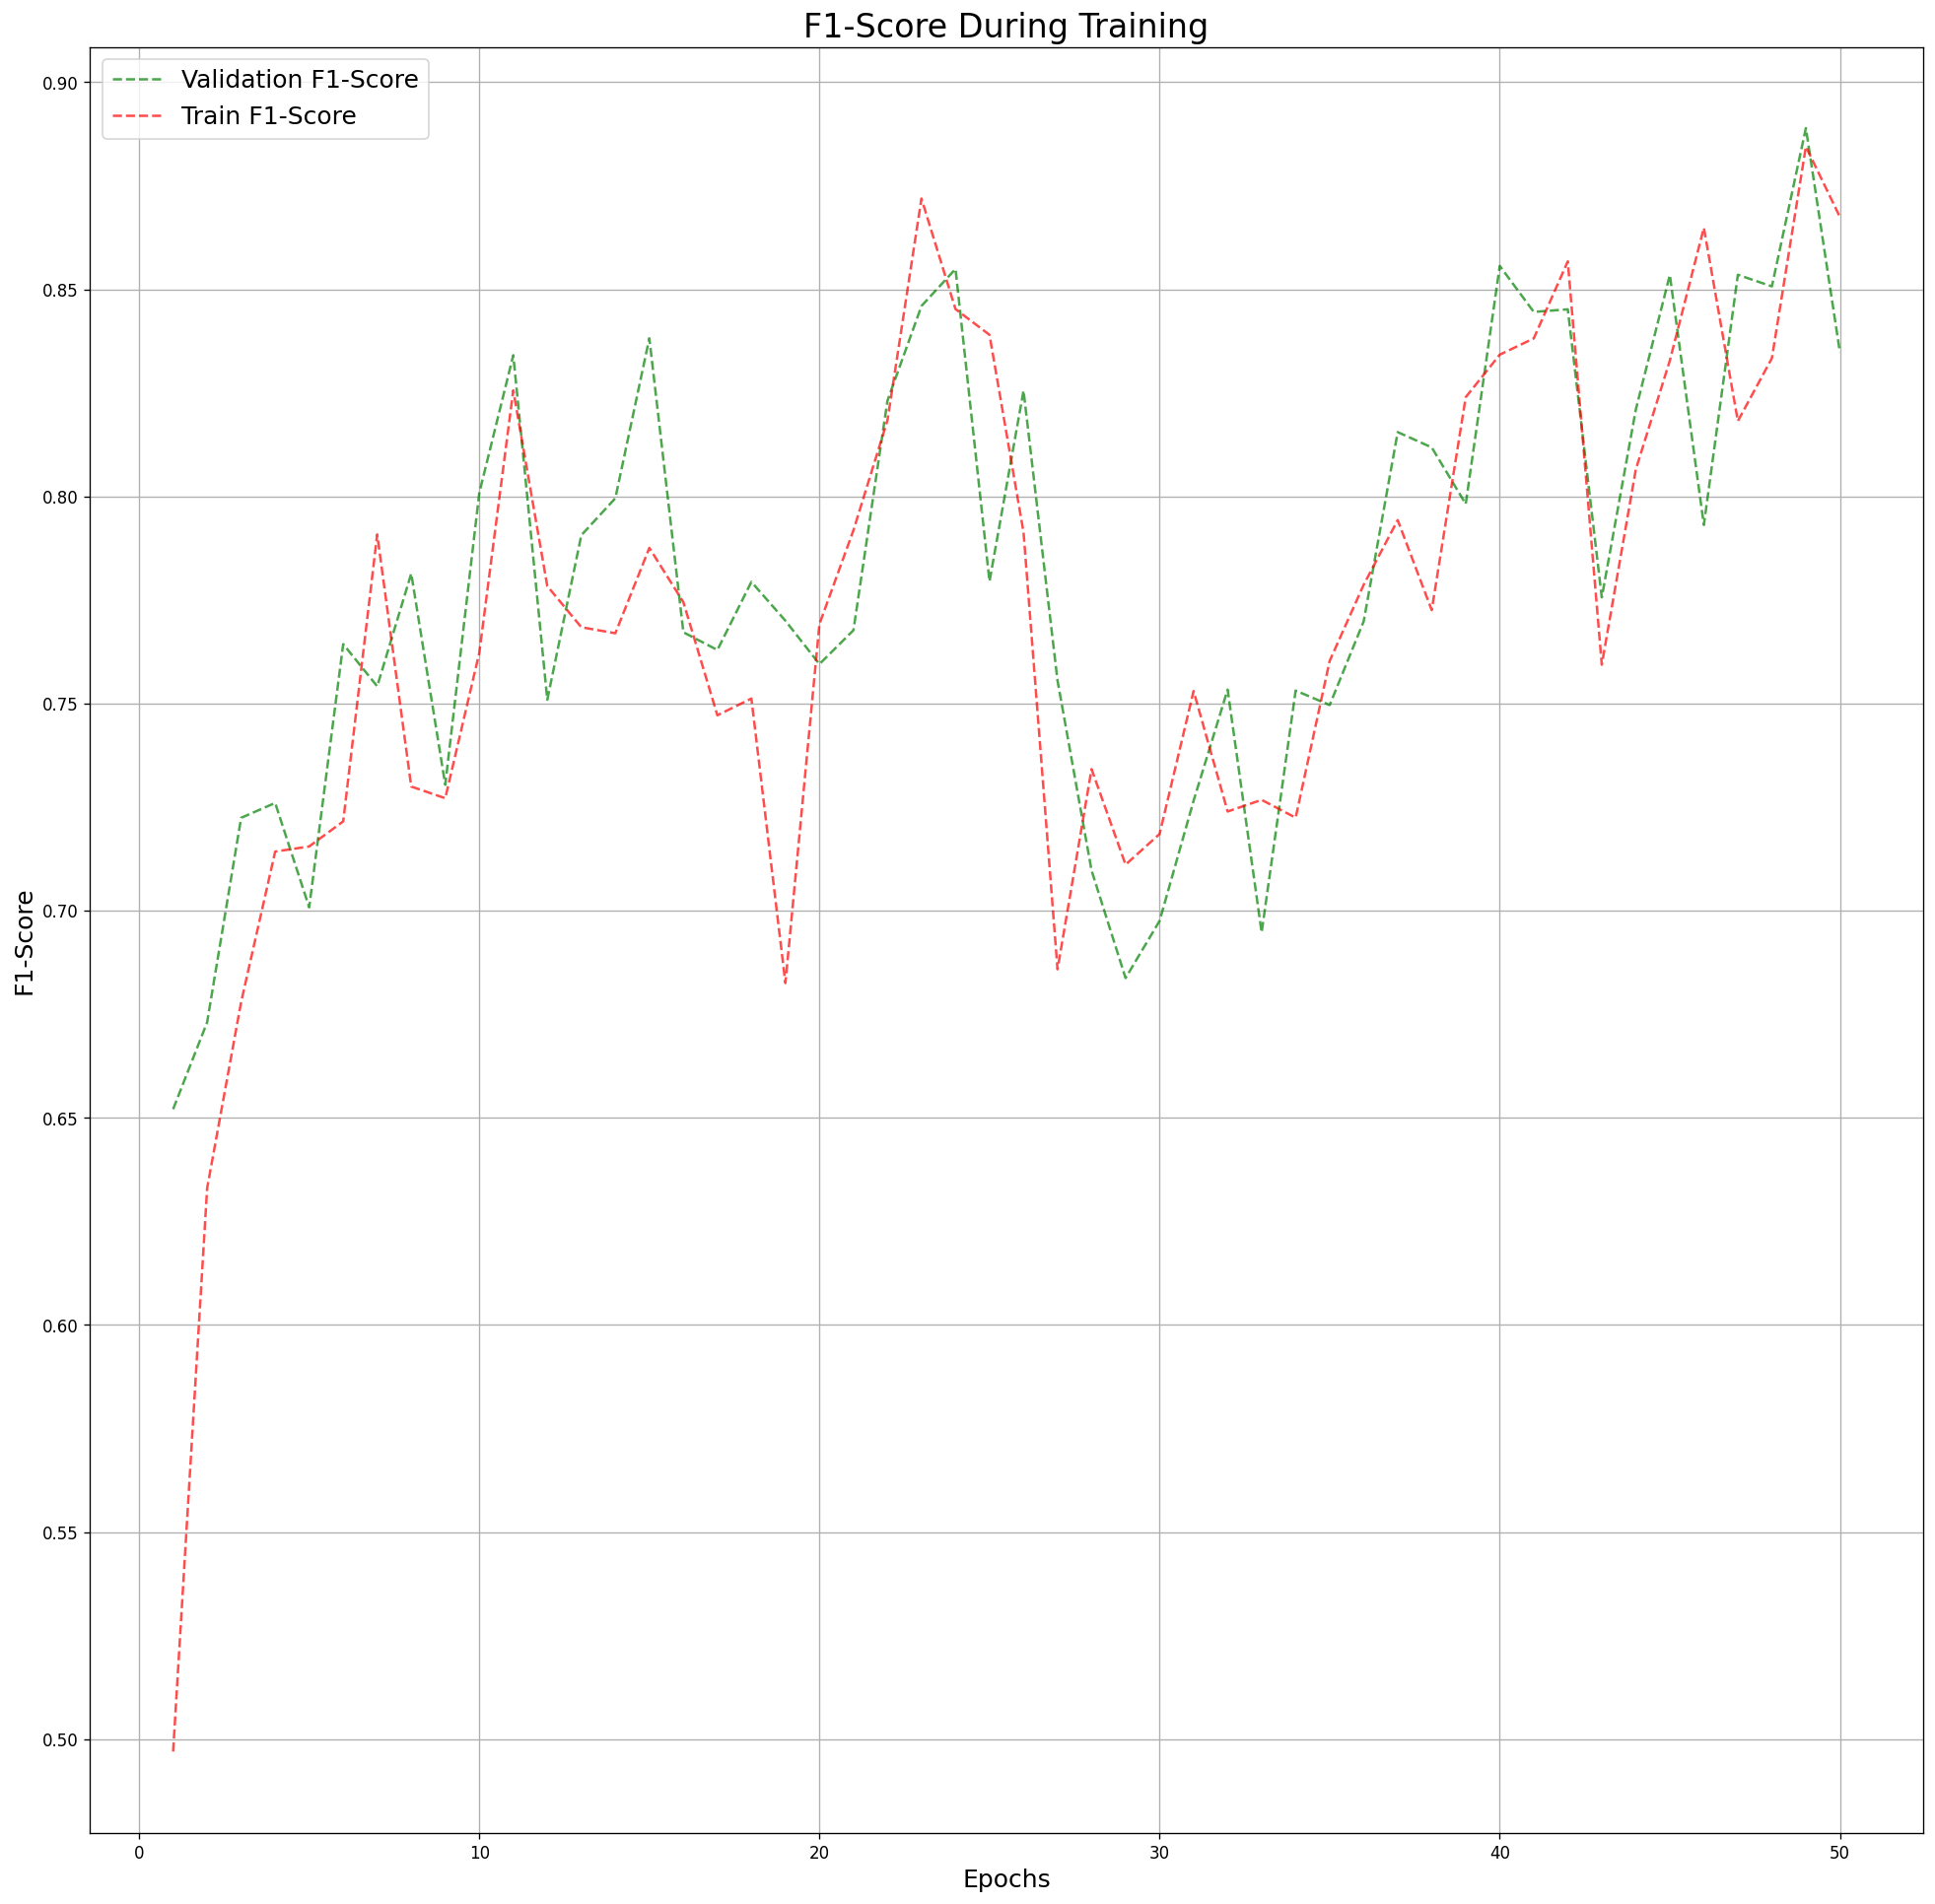

In [23]:
fig, axs = plt.subplots(figsize=(20,20), dpi=120)
axs.grid(True)
axs.set_title("F1-Score During Training", fontsize=20)
axs.set_xlabel("Epochs", fontsize=15)
axs.set_ylabel("F1-Score", fontsize=15)

n_epohchs = np.arange(len(train_metrics)) + 1
axs.plot(n_epohchs, [x[-2] for x in test_metrics], 'g--', label="Validation F1-Score", alpha=0.7)
axs.plot(n_epohchs, [x[-2] for x in train_metrics], 'r--', label="Train F1-Score", alpha=0.7)

axs.legend(loc='best', fontsize=15)

plt.show()

#### Test on unseen data

In [24]:
with torch.no_grad():
    classifier_model.eval()
    x_encoded  = torch.from_numpy(classifier_test[:,:,2:]).float().cuda() # eeg channels
    y = stress_2_label(classifier_test[:,:,1].mean(axis=-1), n_classes).astype(int)
    y_hat = F.softmax(classifier_model(x_encoded).detach(), dim=-1).cpu().numpy()
    labels = y
    preds = y_hat

Precision: 0.5714394601640979
Recall: 0.844737023982307
F1-Score: 0.610784795021221


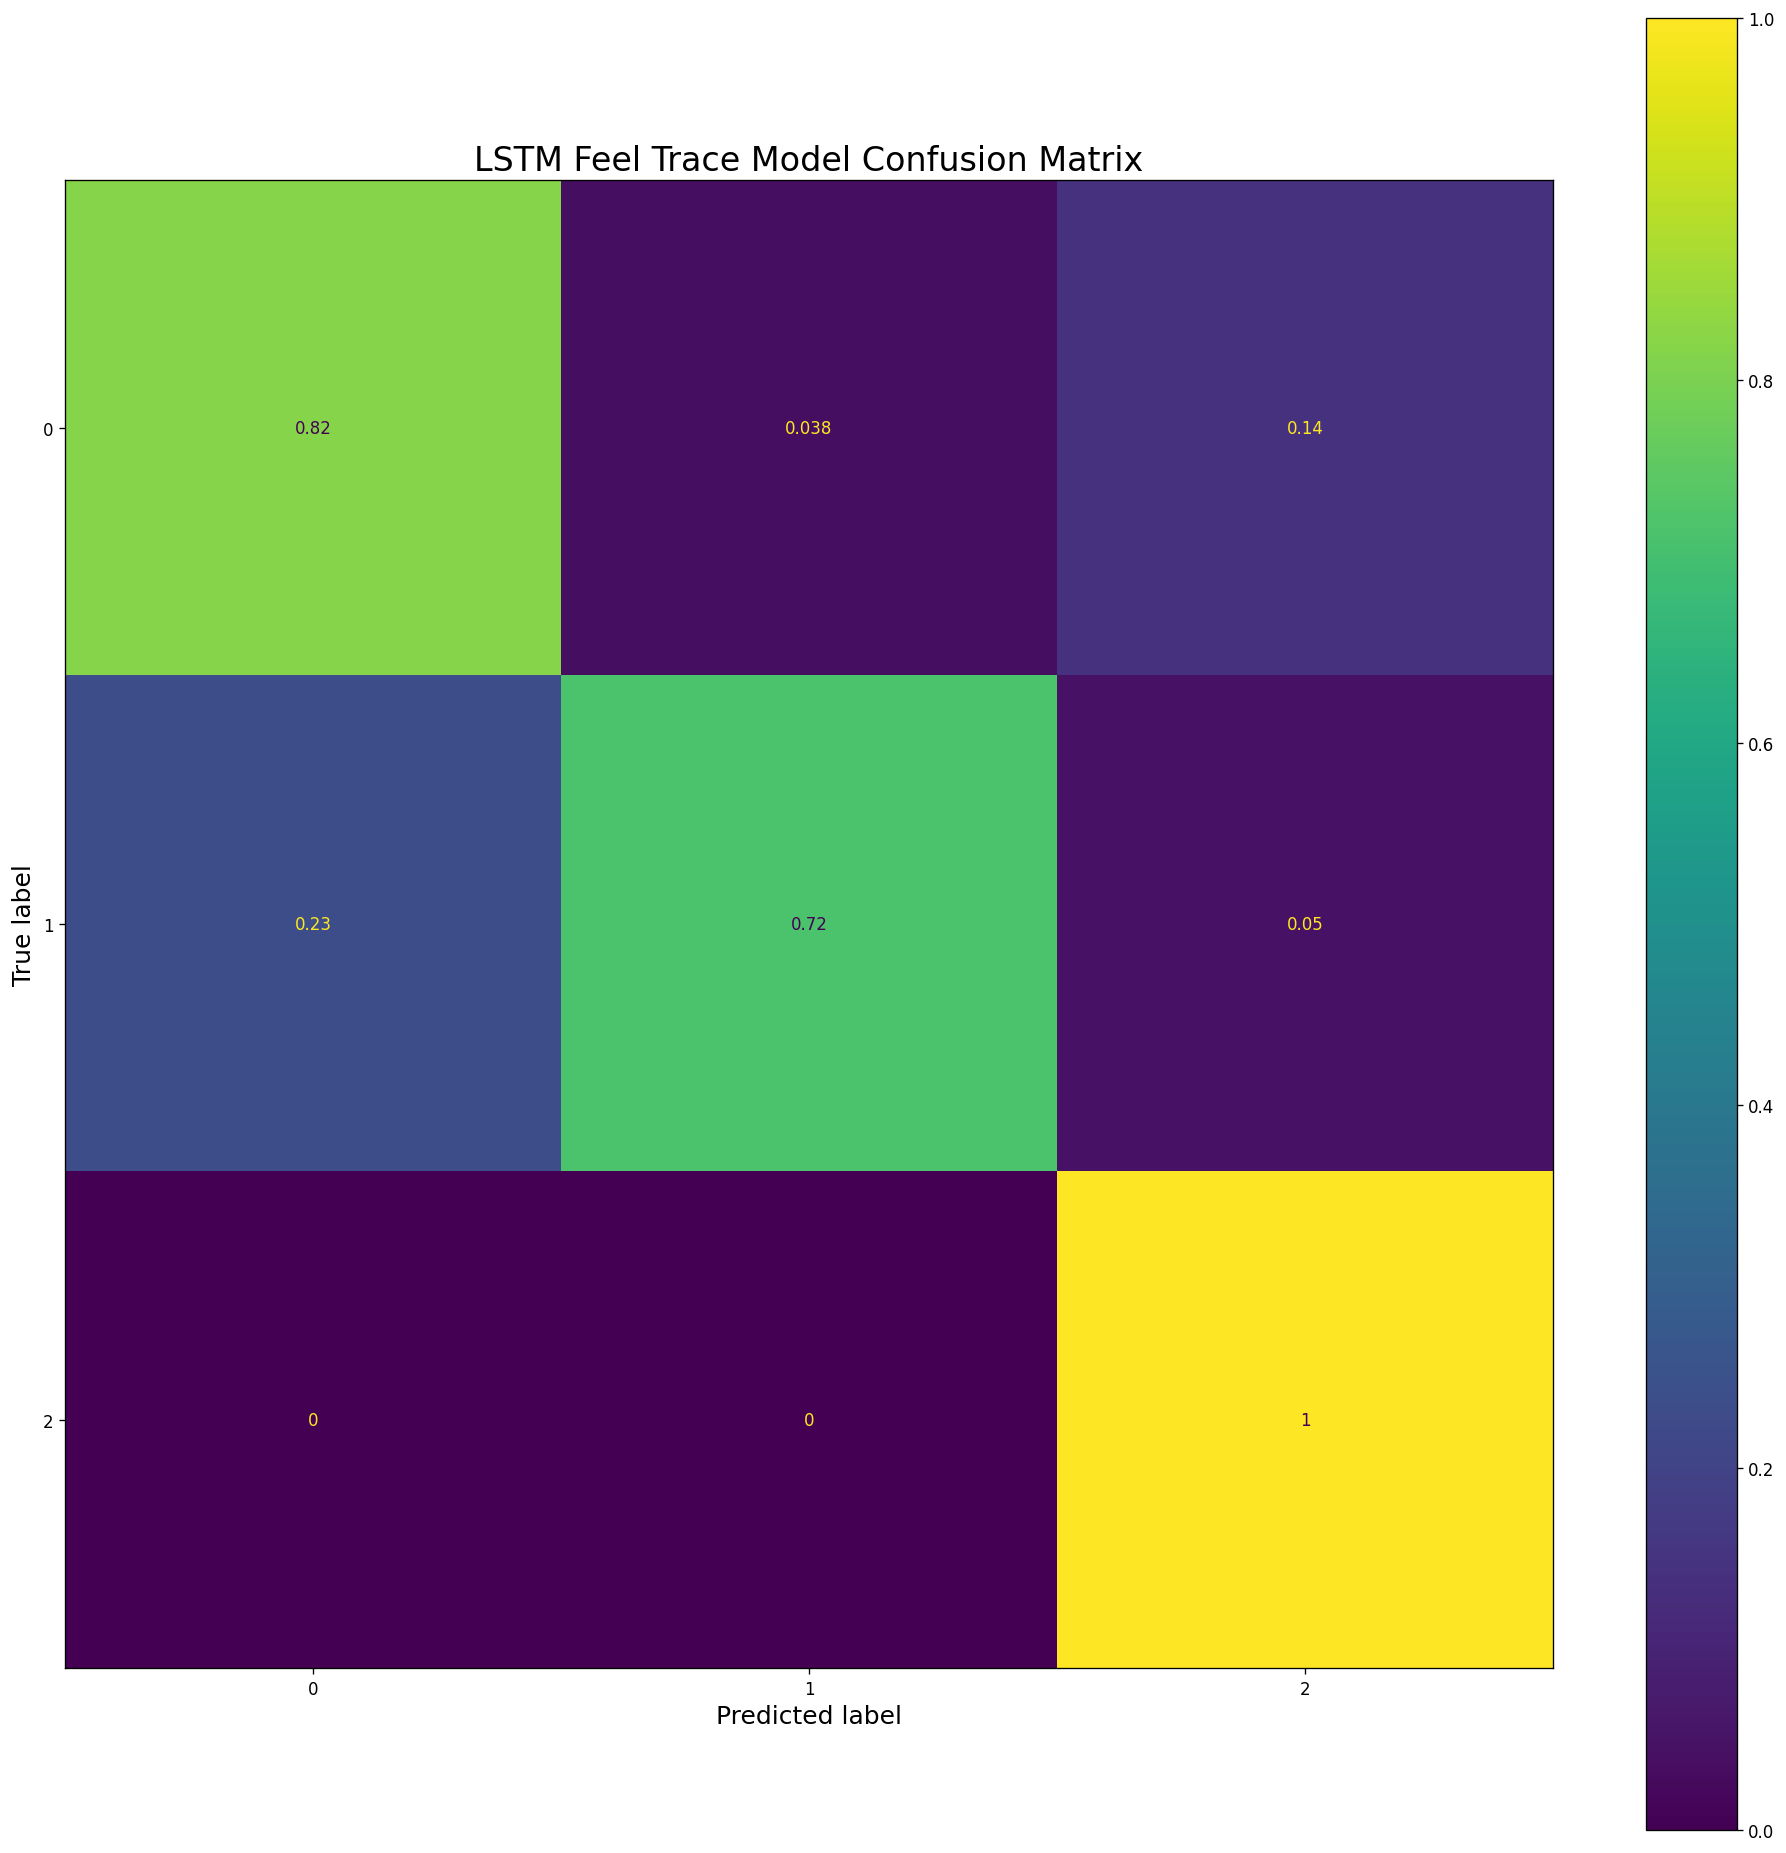

In [25]:
fig, axs = plt.subplots(figsize=(20,20), dpi=120)
axs.set_title("LSTM Feel Trace Model Confusion Matrix", fontsize=20)
axs.set_xlabel("Predicted Label", fontsize=15)
axs.set_ylabel("True Label", fontsize=15)


prf = precision_recall_fscore_support(labels, np.array([x.argmax() for x in preds]), average='macro', zero_division=0)
print(f"Precision: {prf[0]}")
print(f"Recall: {prf[1]}")
print(f"F1-Score: {prf[2]}")

cm = confusion_matrix(labels, [x.argmax() for x in preds], labels=np.arange(n_classes), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))

disp.plot(ax=axs)
plt.show()